# BLG 549E HOMEWORK 2

## 1.Bellman Ford Shortest Path Algoritm

### (1.1) Explain the key steps of Bellman-Ford algorithm (one-by-one).

### (1.2) Write a function called BellmanFordAlgo that takes (i) A and (2) a starting node ID as inputs, and outputs an array

In [31]:
import numpy as np
import scipy.io
import networkx as nx
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from skimage  import data, segmentation, color

In [2]:
def BellmanFordAlgo(A, source): 
    index=[i for i in range (1,len(A)+1)]
    output_attributes=['node', 'shortest distance from source input node','previous node']
    df=pd.DataFrame(columns=output_attributes, index=index)
  
    distance=[math.inf]*len(A)
    distance[source-1]=0

    for k in range(len(A)-1):
        for i in range(len(A)):
            for j in range(0, len(A)):
                if A[i][j] !=0:
                    if (distance[i] != float("inf") and distance[i] + A[i][j]< distance[j]):
                        distance[j] = distance[i]+ A[i][j]
                        
                        df.iloc[source-1][1]=distance[source-1]
                        df.iloc[source-1][2]=source
                        df.iloc[j][0]=j+1 #for indexing
                        df.iloc[j][1]= distance[j]
                        df.iloc[j][2]=i+1
    
    #negative weight cycle means there is another shorter path, which means calculations above are invalid!
    for i in range(len(A)):
        for j in range(len(A)):
            if A[i][j] !=0:
                if (distance[i] !=  float("inf") and distance[i] + A[i][j]< distance[j]):
                    print("Error: Graph contains negative weight cycle")
    df['node']=[i for i in range (1,len(A)+1)]

    return df

### (1.3) Run your function in the Jupyter Notebook on the input adjacency matrix A and display the output array.

In [3]:
f = scipy.io.loadmat('Exercise_1_data/adjacencyMatrix.mat')
A = f["A"]

G = nx.from_numpy_matrix(A)
labels = nx.get_edge_attributes(G,'weight')
pos=nx.spring_layout(G)

{(0, 1): Text(0.1595498673677457, 0.22132762942941614, '1'),
 (0, 2): Text(-0.10864509543408897, -0.36436742702308056, '2'),
 (1, 3): Text(0.19702213277177286, 0.41394102461804305, '4'),
 (1, 5): Text(-0.042786105298840305, -0.21762967423373125, '-2'),
 (2, 5): Text(-0.310981068100675, -0.8033247306862279, '3'),
 (3, 4): Text(0.15143120073292918, 0.5819971012568117, '3'),
 (3, 5): Text(-0.16191082408904314, -0.3684293011482256, '1'),
 (4, 5): Text(-0.088377037337684, -0.049573597594962604, '-1')}

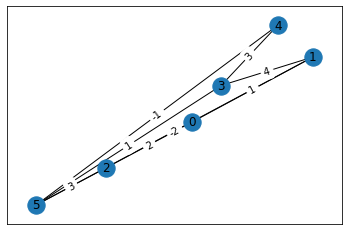

In [4]:
#Interpreting the Graph created from adjacency matrix
nx.draw_networkx(G,pos)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [5]:
BellmanFordAlgo(A, 0)
#Results of Bellman Ford Algorithm

,node,shortest distance from source input node,previous node
1,1,NaN,NaN
2,2,-2,6
3,3,NaN,NaN
4,4,2,2
5,5,5,4
6,6,0,0


## 2 Global efficiency, diffusion efficiency and graph morphospace

### (2.1) Write a function globalEfficiency, which inputs a graph adjacency matrix A and outputs the global efficiency value.

In [6]:
def globalEfficiency(A):
    G=nx.from_numpy_array(A)
    norm=1 / (len(G.nodes) * (len(G.nodes) - 1))
    
    path_lengths = nx.all_pairs_dijkstra_path_length(G, weight="weight")
    L=dict(path_lengths)
    efficiency=0
    for i in G.nodes:
        for j in range(len(L[i])):
            if np.array(list(L[i].values()))[j] != 0:
                efficiency+=(1/np.array(list(L[i].values()))[j])
    return efficiency*norm

### (2.2) Write a function diffusionEfficiency, which inputs a graph adjacency matrix A and outputs the diffusion efficiency value.

In [7]:
#Strategy: Compute matrix U and find shortest path probability 
#            U = A x S^-1
def U_from_A(A):
    S=[]
    for i in range(len(A)):
        s=0
        for j in range(len(A)):
            s+=A[i][j]
        S.append(s)
    S_inv=np.linalg.inv(np.diag(S))
    
    return np.linalg.multi_dot([A, S_inv])  

def diffusionEfficiency(A):
    norm=1/(len(A)*(len(A)-1))
    D=0 
    for j in range(len(A)):
        U=U_from_A(A)
        U[j]=[0 for i in U[j]]
        U=1/(1-U)
        for i in range(len(A)):
            if i!=j:
                x=0
                for n in range(len(A)):
                    x+=U[n][i]
                if x!=0:
                    D+=1/x
    return D*norm    

### (2.3) Create a scatter plot where x-axis represents threshold value  α  ε [0 : 0.1 : 0.9] (0.1 denotes the threshold step size) and the y-axis represents the global efficiency Eglob of brain graph adjacency matrices `Exercise 2 data/ brainGraph1.mat' and `Exercise 2 data/ brainGraph2.mat' (Fig. fig:2). By thresholding each adjacency matrix at different threshold values α  ε [0 : 0.1 : 0.9], examine how its global and diffusion efficiencies change. Use two different colors to compare the change in global efficiency across both brain graphs.

In [8]:
def thresholdNumpyArray(A, alpha):
    thresholded=np.zeros([len(A), len(A)])
    for i in range(len(A)):
        for j in range(0, len(A)):
            if A[i][j]<alpha:
                thresholded[i][j]=0
            else:
                thresholded[i][j]=A[i][j]
    return thresholded  

In [9]:
brainGraph1 = scipy.io.loadmat('Exercise_2_data/brainGraph1.mat')
brainMatrix1 = brainGraph1["W"]

brainGraph2 = scipy.io.loadmat('Exercise_2_data/brainGraph2.mat')
brainMatrix2 = brainGraph2["W"]

thresholds = np.arange(0, 1, 0.1)

globalEfficiencies1 = [globalEfficiency(thresholdNumpyArray(brainMatrix1, i)) for i in thresholds]
globalEfficiencies2 = [globalEfficiency(thresholdNumpyArray(brainMatrix2, i)) for i in thresholds]

diffusionEfficiencies1 = [diffusionEfficiency(thresholdNumpyArray(brainMatrix1, i)) for i in thresholds]
diffusionEfficiencies2 = [diffusionEfficiency(thresholdNumpyArray(brainMatrix2, i)) for i in thresholds]

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_15080/405825433.py:20: RuntimeWarning: divide by zero encountered in true_divide
  U=1/(1-U)


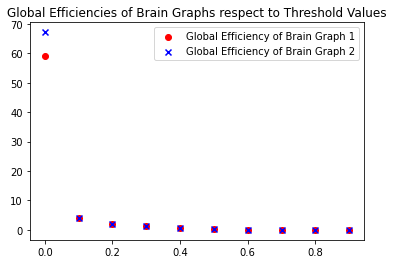

In [10]:
plt.scatter(thresholds, globalEfficiencies1, c='r', marker='o', label='Global Efficiency of Brain Graph 1')
plt.scatter(thresholds, globalEfficiencies2, c='b', marker='x', label='Global Efficiency of Brain Graph 2')
plt.legend()
plt.title('Global Efficiencies of Brain Graphs respect to Threshold Values')
plt.show()

### (2.4) In a second figure, plot the diffusion efficiency Ediff of both matrices against alpha.

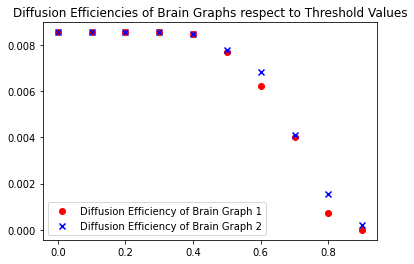

In [11]:
plt.scatter(thresholds, diffusionEfficiencies1, c='r', marker='o', label='Diffusion Efficiency of Brain Graph 1')
plt.scatter(thresholds, diffusionEfficiencies2, c='b', marker='x', label='Diffusion Efficiency of Brain Graph 2')
plt.legend()
plt.title('Diffusion Efficiencies of Brain Graphs respect to Threshold Values')
plt.show()

### (2.5) What conclusions can you derive from previous plots? Compare diffusion and global efficiencies within a single graph and across both graphs.

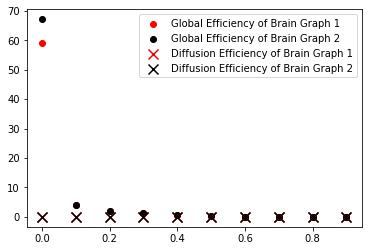

In [12]:
plt.scatter(thresholds, globalEfficiencies1, c='r', marker='o', label='Global Efficiency of Brain Graph 1')
plt.scatter(thresholds, globalEfficiencies2, c='k', marker='o', label='Global Efficiency of Brain Graph 2')

plt.scatter(thresholds, diffusionEfficiencies1, c='r', marker='x', s=100, label='Diffusion Efficiency of Brain Graph 1')
plt.scatter(thresholds, diffusionEfficiencies2, c='k', marker='x', s=100, label='Diffusion Efficiency of Brain Graph 2')

plt.legend()
plt.show()

Since diffusion efficiency values are in 0 and 0.008 they are not interpreted distinguishable. Value range of global efficiencies is too greater than value range of diffusion efficiencies.

In [13]:
print("Value range of Diffusion Efficiencies 1: " + str(max(diffusionEfficiencies1) - min(diffusionEfficiencies1)))
print("Value range of Diffusion Efficiencies 1: " + str(max(globalEfficiencies1) - min(globalEfficiencies1)))

Value range of Diffusion Efficiencies 1: 0.008545271352377743
Value range of Diffusion Efficiencies 1: 59.09230732440917


When all plots are investigated, my comments are:

- Threshold values bigger than 0.0 has decreased global efficiencies for both brain graphs. The only distinguishable values are obtained when threshold equals to 0.
- For diffusion efficiencies, thresholds between 0 and 0.5 caused approximately equal results for two brain graphs. After threshold 0.5, diffusion efficiency values are decreased for both brain graphs.

### (2.6) Plot a morphospace for the set of thresholded brain graphs at α  ε [0 : 0.1 : 0.9], where the x-axis denotes Ediff and y-axis denotes Eglob. Use two different colors to compare the two thresholded graph sets derived from each brain graph, respectively.

In [14]:
morpho1 = pd.DataFrame(columns=["global_efficiency", "diffusion_efficiency"], index=thresholds)
morpho1.global_efficiency = globalEfficiencies1
morpho1.diffusion_efficiency = diffusionEfficiencies1

morpho2 = pd.DataFrame(columns=["global_efficiency", "diffusion_efficiency"], index=thresholds)
morpho2.global_efficiency = globalEfficiencies2
morpho2.diffusion_efficiency = diffusionEfficiencies2


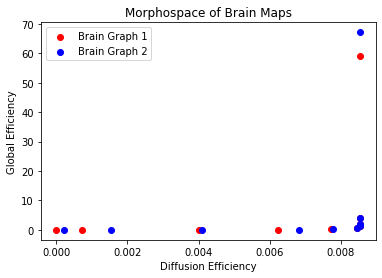

In [15]:
plt.scatter(data=morpho1, x="diffusion_efficiency", y="global_efficiency", c="r", label= 'Brain Graph 1')
plt.scatter(data=morpho2, x="diffusion_efficiency", y="global_efficiency", c="b", label= 'Brain Graph 2')
plt.legend()
plt.ylabel('Global Efficiency')
plt.xlabel('Diffusion Efficiency')
plt.title("Morphospace of Brain Maps")
plt.show()

### (2.7) Discuss the information flow efficiency for both brain graphs based on your morphospace plot.

For both brain graphs, information flow efficiency is decreased by increasing threshold value. After 0.8 threshold, efficiency has decreased with a huge acceleration. Higher threshold makes this graphs vulnerable to targeted attacks.

## 3 Graph self-diffusion for image segmentation

### (3.1) Write a function called selfDiffuse that takes (i) a weighted graph adjacency matrix (i.e., similarity matrix) W and outputs the diffused matrix W* (check algorithm fig:3.). Make sure that your algorithm automatically sets the optimal number of diffusion iterations t* as explained in the paper [2].

In [16]:
#function to find t optimal
def t_optimal(W,P):
    #the eigenvalues of P matrix in descending order
    eigenvalues, eigenvectors= np.linalg.eig(P)
    sorter = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorter]
    #first ln 
    wp = np.dot(W,P)
    n = len(eigenvalues)
    denom1 = n -P.trace()
    denom2 = np.linalg.norm(W-wp-np.identity(len(W)))
    denom = denom1*denom2
    ln_nominator = math.log(0.0001/denom) 
    ln_denominator = math.log(eigenvalues[1]-0.05) # C is set to 0.05 as authors indicate that 0.05 found as the best value for C
    t = np.ceil(ln_nominator/ln_denominator)

    return int(t)

def selfDiffuse(W):
    D=[]
    for i in range(len(W)):
        wd=0
        for j in range (0, len(W)):
            wd+=W[i][j]
        D.append(wd)
    D_inv=np.linalg.inv(np.diag(D)) 
    P=np.dot(D_inv,W)

    for i in range (t_optimal(W,P)):
        W=np.dot(W,P)+np.identity(len(W))
    return np.dot(W,D_inv)

### (3.2) Run selfDiffuse on both brain graph adjacency matrices `Exercise 2 data/brainGraph1.mat` and `Exercise 2 data/ brainGraph2.mat`. For each brain graph, visualize both original and diffused matrices.

In [17]:
selfDiffused1 = selfDiffuse(brainMatrix1)
selfDiffused2 = selfDiffuse(brainMatrix2)

<AxesSubplot:title={'center':'Self Diffused Map of Brain Graph 1'}>

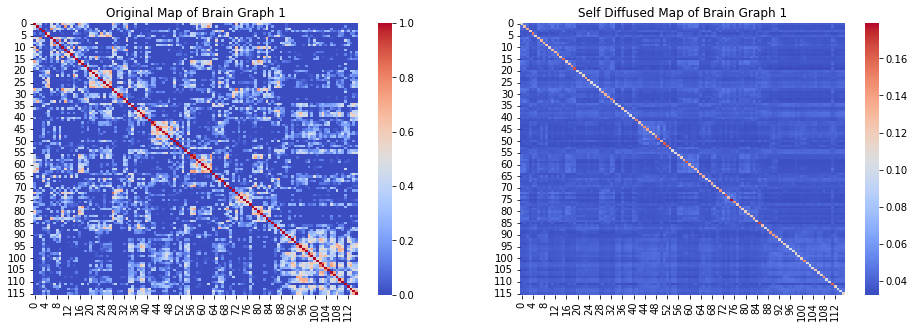

In [18]:
fig= plt.figure(figsize=(16,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_title('Original Map of Brain Graph 1')
ax2.set_title('Self Diffused Map of Brain Graph 1')
sns.heatmap(pd.DataFrame(brainMatrix1),cmap="coolwarm", ax=ax1)
sns.heatmap(pd.DataFrame(selfDiffused1),cmap="coolwarm", ax=ax2 )

<AxesSubplot:title={'center':'Self Diffused Map of Brain Graph 2'}>

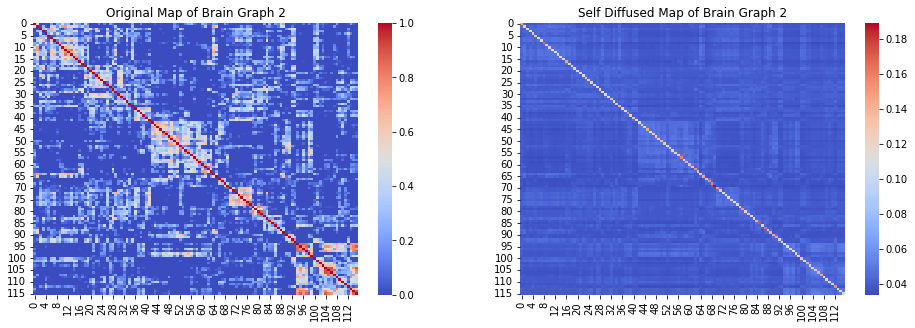

In [19]:
fig= plt.figure(figsize=(16,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_title('Original Map of Brain Graph 2')
ax2.set_title('Self Diffused Map of Brain Graph 2')
sns.heatmap(pd.DataFrame(brainMatrix2),cmap="coolwarm", ax=ax1)
sns.heatmap(pd.DataFrame(selfDiffused2),cmap="coolwarm", ax=ax2 )

### (3.3) Given the 2 images taken from the Berkeley Segmentation Data Set, generate the segmentation maps of each image using the Normalized Cut Python code https://github.com/marktao99/python/blob/master/CVP/samples/ncut.py. Display each original image and its corresponding output segmentation map.

In [44]:
from PIL import Image
from pylab import *
from numpy import *
from scipy.cluster.vq import *


def cluster(S,k,ndim):
    """ Spectral clustering from a similarity matrix."""
    
    # check for symmetry
    if sum(abs(S-S.T)) > 1e-10:
        print('not symmetric')
    
    # create Laplacian matrix
    rowsum = sum(abs(S),axis=0)
    D = diag(1 / sqrt(rowsum + 1e-6))
    L = dot(D,dot(S,D))
    
    # compute eigenvectors of L
    U,sigma,V = linalg.svd(L,full_matrices=False)
    
    # create feature vector from ndim first eigenvectors
    # by stacking eigenvectors as columns
    features = array(V[:ndim]).T

    # k-means
    features = whiten(features)
    centroids,distortion = kmeans(features,k)
    code,distance = vq(features,centroids)
        
    return code,V


def ncut_graph_matrix(im,sigma_d=1e2,sigma_g=1e-2):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * exp(-d/sigma_d)
    
    return W

In [48]:
def ncut_segmentation(image_path):
    image=Image.open(image_path) 

    #Image resolution decreased due to memory issues
    image = image.resize((int(list(image.size)[0]/8),int(list(image.size)[1]/8)),Image.NEAREST)    
    ncut_matrix1=ncut_graph_matrix(np.asarray(image).astype(np.float32))
    l1, V= cluster(ncut_matrix1,2,1)
    l2, V= cluster(ncut_matrix1,3,2)
    y,x = np.array(image1).shape[:2]
    
    #labels are reshaped according to the shape of the image
    labels_1=np.array(l1).reshape(y,x)
    labels_2=np.array(l2).reshape(y,x)

    segmentation_1 = color.label2rgb(labels_1, np.array(image), kind='avg', bg_label=0)
    segmentation_2 = color.label2rgb(labels_2, np.array(image), kind='avg', bg_label=0)

    fig, ax = plt.subplots(nrows= 3,sharex=True, figsize=(15, 10))
    ax[0].set_title('Original Image')
    ax[0].imshow(image1)
    ax[1].set_title('NCut Segmentation with 2 Clusters')
    ax[1].imshow(segmentation_1)
    ax[2].set_title('NCut Segmentation with 3 Clusters')
    ax[2].imshow(segmentation_2)
    plt.show()

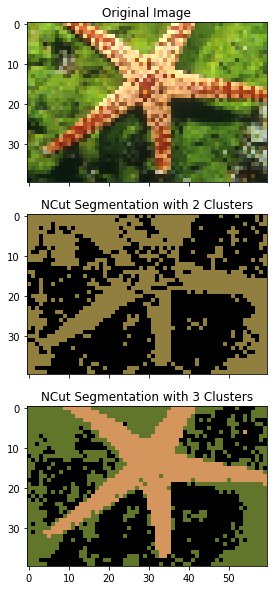

In [49]:
ncut_segmentation('Exercise_3_data/image1.jpg')

In [50]:
ncut_segmentation('Exercise_3_data/image2.jpg')

IndexError: index 42 is out of bounds for axis 1 with size 40